In [50]:
from scipy import sparse, io
import pandas as pd
import numpy as np
import matplotlib as plt
import pyreadr as pyreadr
from tqdm import tqdm
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import scipy.spatial as sp
from scipy.spatial.distance import pdist, jaccard
import matplotlib.pyplot as plt
import h5py
import time
from __future__ import division
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mygene

# Data Processing and EDA

In [4]:
def get_df(paths):
    
    mat_file = paths[0]
    row_file = paths[1]
    if len(paths)>2:
        col_file = paths[2]
    sparsematrix = io.mmread(mat_file)
    m_dense = sparsematrix.toarray()
    var_names = np.genfromtxt(row_file, dtype=str)
    if len(paths)>2:
        col_names = np.genfromtxt(col_file, dtype=str)
    if len(paths)>2:
        df = pd.DataFrame(m_dense, columns=col_names, index=var_names)
    else:
        df = pd.DataFrame(m_dense, index=var_names)
    return df
    

In [5]:
scRNA_paths = 

scATAC_paths = 

start = time.process_time()
scRNA = get_df(scRNA_paths)
scATAC = get_df(scATAC_paths)


#get the metadata file with info for each cell
cell_meta_data = pd.read_csv()

#only need the labels and the cell ID so drop everything else
cell_meta_data = cell_meta_data.loc[:, ['Cell.ID', 'seurat_clusters']]

#make sure all three dataframes have the same ordering of cells (index wise)
cell_meta_data.set_index('Cell.ID', inplace = True)
scRNA = scRNA.reindex(scATAC.index)

#replace the seurat clusters with the actual biological classes
cell_meta_data = cell_meta_data.reindex(scATAC.index)
cluster_names = pd.read_csv('multiome_cluster_names.txt', sep = "\t")
cluster_maps = {k: v for k, v in zip(cluster_names['Cluster.ID'], cluster_names['Cluster.Name'])}
cell_meta_data['seurat_clusters'] = cell_meta_data['seurat_clusters'].map(cluster_maps)
labels = list(cell_meta_data['seurat_clusters'])

In [6]:
print("There are:", len(np.unique(cell_meta_data['seurat_clusters'])), "classes.")

There are: 14 classes.


In [7]:
print("scATAC:")
scATAC.head(3)

scATAC:


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA,2,2,0,4,0,0,4,0,2,2,...,0,0,0,0,0,0,0,0,0,0
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA,3,0,5,2,6,0,0,0,0,2,...,0,0,0,0,2,0,0,0,0,0
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA,3,2,0,4,6,4,6,0,4,4,...,0,2,0,2,0,2,0,0,2,1


In [8]:
print("scRNA:")
scRNA.head(3)

scRNA:


,ENSG00000251562,ENSG00000198938,ENSG00000198899,ENSG00000198804,ENSG00000198712,ENSG00000078328,ENSG00000178568,ENSG00000198886,ENSG00000271860,ENSG00000185008,...,ENSG00000177426,ENSG00000165152,ENSG00000188783,ENSG00000110107,ENSG00000064703,ENSG00000167733,ENSG00000101346,ENSG00000204344,ENSG00000204568,ENSG00000140464
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA,46,0,0,0,1,14,0,0,0,24,...,0,0,0,0,0,0,0,0,0,0
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA,83,7,8,2,1,3,46,2,3,0,...,0,0,0,0,0,0,0,0,0,0
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA,164,34,14,12,10,11,0,4,41,17,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print("metadata:")
(cell_meta_data.head(3))

metadata:


,seurat_clusters
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA,mGPC/OPC
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA,IN1
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA,GluN3


# Vanilla NN

In [23]:
!nvidia-smi

Tue Nov 14 16:56:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:18:00.0 Off |                    0 |
| N/A   48C    P0              73W / 300W |    449MiB / 16384MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(10000, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 14)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1) 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
#taken from ece523
def train_NN(net, optimizer, device, trainloader, criterion, num_epochs=5):
    if torch.cuda.is_available():
        net.to(device)
    net.train()

    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            # Get the inputs and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    print('Finished Training')
    return net

In [18]:
def test_NN(net, testloader):
    net.eval()
    total = 0
    correct = 0
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            #keep a list of the predicted labels so can compute confusion matrix later
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    print("Accuracy: ", 100 * correct // total)
    return predicted_labels, true_labels
    
        

In [19]:
def get_data(data_type, scRNA, scATAC, labels):
    
    if data_type == "scRNA":
        data = scRNA
    else:
        data = scATAC
    
    label_encoder = LabelEncoder()
    encoded_types = label_encoder.fit_transform(labels)

    #make both data types into a tensor
    sc_tensor = torch.tensor(data.to_numpy(), dtype=torch.float32)
    encoded_type_tensor = torch.tensor(encoded_types, dtype=torch.int64)
    full_dataset = torch.utils.data.TensorDataset(sc_tensor, encoded_type_tensor)


    #split into train, test and validation the paper did a 80-10-10 split
    train_size = int(0.8 * len(full_dataset))
    val_test_size = (len(full_dataset) - train_size)/2
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, int(val_test_size-.5), int(val_test_size+.5)])
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers = 2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, num_workers = 2)
    testloader =  torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers = 2)
    
    return trainloader, valloader, testloader
        
        
        

In [31]:
def plot_confusion_matrix(labels, true, pred, title):
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = np.unique(labels))
    print(title)
    disp.plot(xticks_rotation='vertical', cmap = 'ocean', )

100%|██████████| 50/50 [00:25<00:00,  1.94it/s]

Finished Training


Accuracy:  89
scRNA baseline confusion matrix


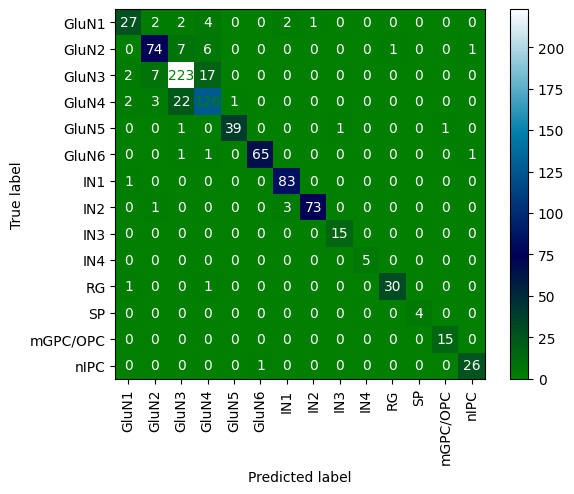

In [32]:
train, val, test = get_data("scRNA", scRNA, scATAC, labels)
net = NN()
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net = train_NN(net, optimizer, device, train, criterion, num_epochs = 50)
predicted_labels, true_labels = test_NN(net, test)
plot_confusion_matrix(labels, true_labels, predicted_labels, "scRNA baseline confusion matrix")

100%|██████████| 50/50 [00:15<00:00,  3.13it/s]

Finished Training


Accuracy:  69
scATAC baseline confusion matrix


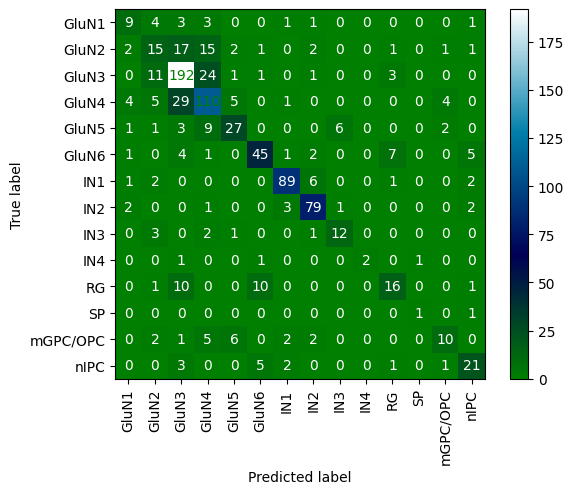

In [33]:
train, val, test = get_data("scATAC", scRNA, scATAC, labels)
net = NN()
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net = train_NN(net, optimizer, device, train, criterion, num_epochs = 50)
predicted_labels, true_labels = test_NN(net, test)
plot_confusion_matrix(labels, true_labels, predicted_labels, "scATAC baseline confusion matrix")

# Autoencoder

In [42]:
known_interactions = pd.read_csv()
known_interactions

,Uniprot_A,Uniprot_B,Gene_A,Gene_B,ORF_A,ORF_B,Alias_A,Alias_B,pmid:method:quality
0,A0A024QYV7,P0CG48,A0A024QYV7,UBC,HCG_1994130,NaN,NaN,HGNC:12468,21906983:0004:LC|21890473:0004:LC|21987572:000...
1,A0A024QYV7,P40337,A0A024QYV7,VHL,HCG_1994130,NaN,NaN,HGNC:12687,21942715:0004:LC|22234250:0004:LC
2,A0A024QYV7,Q00653,A0A024QYV7,NFKB2,HCG_1994130,NaN,NaN,HGNC:7795,14743216:0007:HT|14743216:0676:HT
3,A0A024QYV7,Q99558,A0A024QYV7,MAP3K14,HCG_1994130,NaN,NaN,HGNC:6853,14743216:0007:HT|14743216:0676:HT
4,A0A024QYV7,Q9Y6K9,A0A024QYV7,IKBKG,HCG_1994130,NaN,NaN,HGNC:5961,14743216:0007:HT|14743216:0676:HT
...,...,...,...,...,...,...,...,...,...
144046,Q9Y6K9,Q9Y6Q9,IKBKG,NCOA3,NaN,NaN,HGNC:5961,HGNC:7670,11971985:0019:LC|11971985:0007:LC|16051665:000...
144047,Q9Y6R1,Q9Y6R1,SLC4A4,SLC4A4,NaN,NaN,HGNC:11030,HGNC:11030,20798035:0007:LC
144048,Q9Y6X8,Q9Y6X8,ZHX2,ZHX2,NaN,NaN,HGNC:18513,HGNC:18513,12741956:0096:LC|12741956:0018:LC
144049,Q9Y6Y0,Q9Y6Y0,IVNS1ABP,IVNS1ABP,HSPC068,HSPC068,HGNC:16951,HGNC:16951,23825951:0004:LC


In [46]:
gene = list(scRNA.columns)
len(gene_cols)

10000

In [ ]:
def make_adj(genes, PPI):
    
    number_of_genes = len(genes)
    adj_matrix = np.zeros(number_of_genes,number_of_genes, dtype=int)
    
    
    